In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
#input train data
data=pd.read_csv('../input/train.csv')
data.shape

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


(1306122, 3)

In [31]:
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [32]:
#data[data['target']==1].head()
data['target'].value_counts() / data.shape[0] * 100
#highly imbalanced class

0    93.812982
1     6.187018
Name: target, dtype: float64

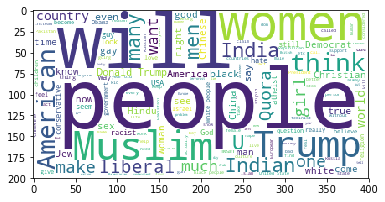

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
insincere_rows=data[data['target']==1]
wc=WordCloud(background_color='white').generate(' '.join(insincere_rows['question_text'])) #word cloud for every class
plt.imshow(wc)
#now we will do for class 1
#for class 0 it will take more time since we have more data

In [34]:
#most insincere questions are aroud trump, religion etc

In [ ]:
sincere_rows=data[data['target']==0]
wc1=WordCloud(background_color='white').generate(' '.join(sincere_rows['question_text'])) #word cloud for every class
plt.imshow(wc1)

In [ ]:
#divide train data into train and test, and validate

In [35]:
from sklearn.model_selection import train_test_split
train,validate=train_test_split(data,test_size=0.3,random_state=1)
train.shape,validate.shape

((914285, 3), (391837, 3))

In [36]:
import nltk
def clean_sentence(doc,stopwords,stemmer):
    words=doc.split(' ')
    words_clean=[stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
    

def clean_documents(docs_raw):
    stopwords=nltk.corpus.stopwords.words('english')
    stemmer=nltk.stem.PorterStemmer()
    docs=docs_raw.str.lower().str.replace('[^a-z ]','')
    docs_clean=docs.apply(lambda doc:clean_sentence(doc,stopwords,stemmer))
    return docs_clean
train_docs_clean=clean_documents(train['question_text'])
train_docs_clean.head()

635414          inhand salari rd prc freshli join mt cil
906079                             one take yolo serious
99492                                  best club nairobi
973656    wake donald trump clock tick  hour return bodi
397612                              made elon musk smart
Name: question_text, dtype: object

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(min_df=10).fit(train_docs_clean)  #min_df, identfy a term whos freq is atleast 10, remove which is less than 10
dtm=vectorizer.transform(train_docs_clean)

In [38]:
dtm

<914285x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 5406880 stored elements in Compressed Sparse Row format>

In [ ]:
#pd.DataFrame(dtm.toarray()) #will get memory error coz data is too large
#so will not convert to dataframe

In [39]:
from sklearn.tree import DecisionTreeClassifier
model_df=DecisionTreeClassifier(max_depth=10).fit(dtm,train['target'])

In [ ]:
#now we will fit the validate data

In [40]:
validate_docs_clean=clean_documents(validate['question_text'])
dtm_validate=vectorizer.transform(validate_docs_clean)
dtm_validate

<391837x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 2313528 stored elements in Compressed Sparse Row format>

In [ ]:
#ypred=model_df.predict(dtm_validate)

In [41]:
validate_pred=model_df.predict(dtm_validate)
from sklearn.metrics import f1_score
f1_score(validate['target'],validate_pred)

0.26098403817673194

In [42]:
from sklearn.naive_bayes import MultinomialNB
model_nb=MultinomialNB().fit(dtm,train['target'])
validate_pred=model_nb.predict(dtm_validate)
f1_score(validate['target'],validate_pred)

0.5425968470252713

In [ ]:
#test data

In [43]:
test=pd.read_csv('../input/test.csv')
test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [45]:
docs_clean=clean_documents(test['question_text'])
dtm_test=vectorizer.transform(docs_clean)
dtm_test

<375806x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 2220720 stored elements in Compressed Sparse Row format>

In [46]:
test_pred=model_nb.predict(dtm_test)

In [48]:
sample_submission=pd.read_csv('../input/sample_submission.csv')
sample_submission.head() #have to submit in this format

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [50]:
submission=pd.DataFrame({'qid':test['qid'],
                        'prediction':test_pred})
submission[['qid','prediction']].to_csv('submission_csv',index=False)